In [1]:
!pip install tqdm
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.3 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models.callbacks import CallbackAny2Vec
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

#Dataset

In [3]:
unbalanced_dataset = pd.read_csv("result.csv")
unbalanced_dataset["label"] = unbalanced_dataset.label.astype("int64")

In [4]:
dataset_label = {
  0:"cobaltstrike",
  1:"bruteratel",
  2:"covenant",
  3:"deimos",
  4:"sliver",
  5:"posh",
  6:"metsploit"
}

Plotting unbalanced dataset

{0: 120, 1: 53, 2: 11, 3: 19, 4: 43, 5: 14, 6: 174}


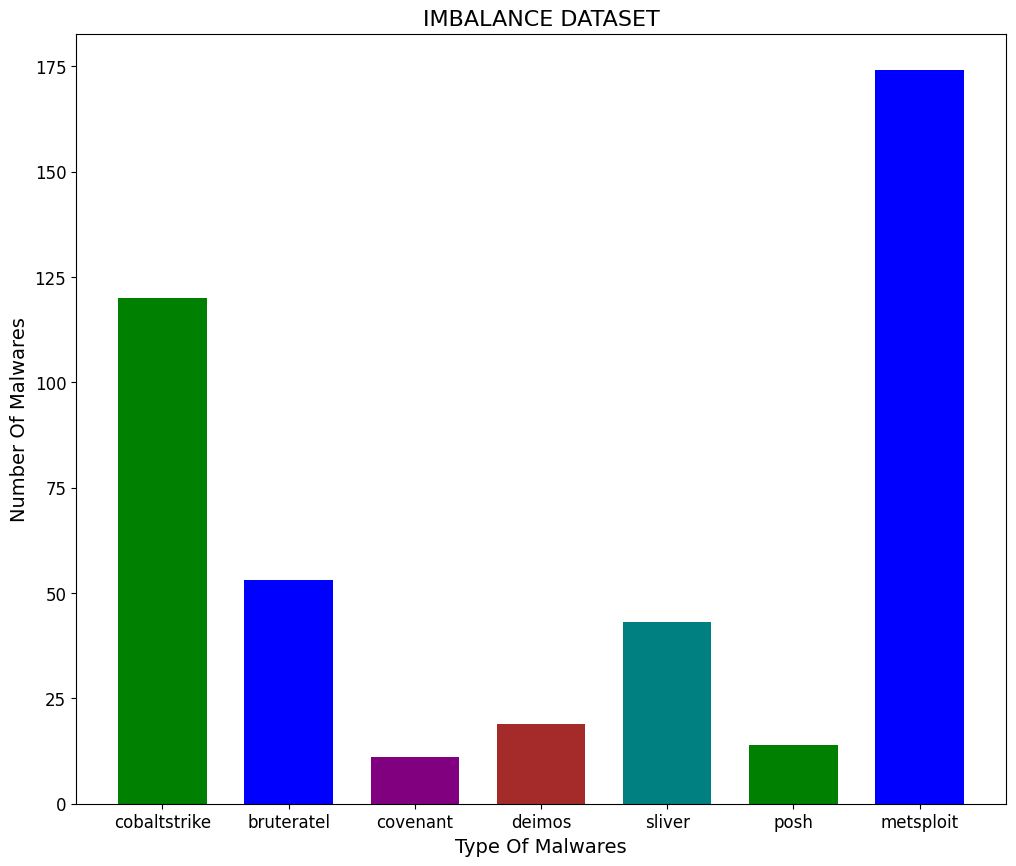

In [5]:
unbalanced_dataset_size = unbalanced_dataset["label"].value_counts().to_dict()
unbalanced_dataset_size = {k: v for k, v in sorted(list(unbalanced_dataset_size.items()))}
print(unbalanced_dataset_size)

names = list(dataset_label.values())
values = list(unbalanced_dataset_size.values())
New_Colors = ["green","blue","purple","brown","teal"]
plt.figure(figsize=(12,10))
plt.bar(names,values,color=New_Colors,width=0.7)
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12)
plt.title("IMBALANCE DATASET",fontsize=16)
plt.xlabel("Type Of Malwares", fontsize=14)
plt.ylabel("Number Of Malwares", fontsize=14)
plt.show()

#Word Embedding

In [6]:
class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f"Epoch {self.epoch}")
        self.epoch += 1

epoch_logger = EpochLogger()

In [7]:
def api_sequence_to_vector(api_sequence, model):
    vector = []
    for api in api_sequence:
        if api in model.wv:
            vector.append(model.wv[api])
        else:
            vector.append([0] * 256)
    return vector

In [8]:
unbalanced_dataset["data"] = unbalanced_dataset["data"].str.split()
unbalanced_dataset

,data,node,edge,label
0,"[Adobe_XMP_Identifier, SizeofResource, WritePr...",411,426,1
1,"[T1129, T1569.002, ChangeServiceConfig2A, Chan...",0,0,1
2,"[T1213, T1056.001, T1222, T1562.004, T1112, T1...",0,0,1
3,"[brc4_shellcode, HKTL_BruteRatel_Badger_Indica...",0,0,1
4,"[ExitProcess, HeapSize, UnhandledExceptionFilt...",0,0,1
...,...,...,...,...
429,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
430,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
431,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4
432,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4


In [9]:
model = Word2Vec(unbalanced_dataset["data"], vector_size=256, window=5, min_count=1, sg=0, callbacks=[epoch_logger])
model.save("word2vec.model")

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [10]:
unbalanced_dataset["data_vector"] = unbalanced_dataset["data"].apply(lambda x: api_sequence_to_vector(x, model))
unbalanced_dataset["data_vector_mean"] = unbalanced_dataset["data_vector"].apply(lambda x: np.mean(x))
unbalanced_dataset["data_vector_std"] = unbalanced_dataset["data_vector"].apply(lambda x: np.std(x))
unbalanced_dataset

,data,node,edge,label,data_vector,data_vector_mean,data_vector_std
0,"[Adobe_XMP_Identifier, SizeofResource, WritePr...",411,426,1,"[[0.0028108736, -0.0037660017, 0.0020904173, 0...",-0.002599,0.265900
1,"[T1129, T1569.002, ChangeServiceConfig2A, Chan...",0,0,1,"[[0.04879712, -0.10318082, -0.014345694, 0.216...",-0.007897,0.326779
2,"[T1213, T1056.001, T1222, T1562.004, T1112, T1...",0,0,1,"[[0.002649557, -0.005615015, 0.001473277, 0.01...",-0.003112,0.191024
3,"[brc4_shellcode, HKTL_BruteRatel_Badger_Indica...",0,0,1,"[[0.018617168, -0.032990776, -0.0011497173, 0....",-0.003143,0.193499
4,"[ExitProcess, HeapSize, UnhandledExceptionFilt...",0,0,1,"[[0.050671913, -0.18494935, 0.13132837, 0.6145...",-0.003157,0.194101
...,...,...,...,...,...,...,...
429,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[-0.12140366, -0.11491648, -0.18420495, 0.232...",-0.002909,0.316241
430,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[-0.12140366, -0.11491648, -0.18420495, 0.232...",-0.002909,0.316241
431,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[-0.12140366, -0.11491648, -0.18420495, 0.232...",-0.002909,0.316241
432,"[WriteFile, WriteConsoleW, WaitForSingleObject...",0,0,4,"[[-0.12140366, -0.11491648, -0.18420495, 0.232...",-0.002909,0.316241


In [11]:
unbalanced_dataset = unbalanced_dataset.drop(columns=["data", "data_vector"])
unbalanced_dataset

,node,edge,label,data_vector_mean,data_vector_std
0,411,426,1,-0.002599,0.265900
1,0,0,1,-0.007897,0.326779
2,0,0,1,-0.003112,0.191024
3,0,0,1,-0.003143,0.193499
4,0,0,1,-0.003157,0.194101
...,...,...,...,...,...
429,0,0,4,-0.002909,0.316241
430,0,0,4,-0.002909,0.316241
431,0,0,4,-0.002909,0.316241
432,0,0,4,-0.002909,0.316241


#Imputation

In [12]:
imputer = SimpleImputer(strategy="mean")
unbalanced_dataset = pd.DataFrame(imputer.fit_transform(unbalanced_dataset), columns=unbalanced_dataset.columns)

#Data Balancing

In [13]:
df_cobaltstrike_0 = unbalanced_dataset[unbalanced_dataset.label == 0][:]
df_bruteratel_1 = unbalanced_dataset[unbalanced_dataset.label == 1][:]
df_covenant_2 = unbalanced_dataset[unbalanced_dataset.label == 2][:]
df_deimos_3 = unbalanced_dataset[unbalanced_dataset.label == 3][:]
df_sliver_4 = unbalanced_dataset[unbalanced_dataset.label == 4][:]
df_posh_5 = unbalanced_dataset[unbalanced_dataset.label == 5][:]
df_metasploit_6 = unbalanced_dataset[unbalanced_dataset.label == 6][:]

Downsampling

In [14]:
def resample_df(df, number_samples):
    from sklearn.utils import resample
    return resample(df, n_samples=number_samples, replace=False, random_state=0)

In [15]:
df_cobaltstrike_resampled = resample_df(df_cobaltstrike_0, 50)
df_bruteratel_resampled = resample_df(df_bruteratel_1, 50)
df_metasploit_resampled = resample_df(df_metasploit_6, 50)

df_cobaltstrike_resampled.reset_index(drop=True, inplace=True)
df_bruteratel_resampled.reset_index(drop=True, inplace=True)
df_metasploit_resampled.reset_index(drop=True, inplace=True)

balanced_dataset = pd.concat([
    df_cobaltstrike_resampled,
    df_bruteratel_resampled,
    df_metasploit_resampled
])

balanced_dataset

,node,edge,label,data_vector_mean,data_vector_std
0,0.0,0.0,0.0,-0.007060,0.361541
1,0.0,0.0,0.0,-0.002680,0.226078
2,0.0,0.0,0.0,-0.006993,0.347797
3,0.0,0.0,0.0,0.002911,0.322412
4,0.0,0.0,0.0,-0.007283,0.358049
...,...,...,...,...,...
45,0.0,0.0,6.0,-0.001342,0.052340
46,0.0,0.0,6.0,-0.003903,0.190875
47,4170.0,5713.0,6.0,-0.007187,0.311256
48,0.0,0.0,6.0,-0.003903,0.190875


Upsampling

In [16]:
balanced_dataset = pd.concat([balanced_dataset, df_covenant_2])

In [17]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(200, 5)

In [18]:
balanced_dataset = pd.concat([balanced_dataset, df_deimos_3])

In [19]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(250, 5)

In [20]:
balanced_dataset = pd.concat([balanced_dataset, df_sliver_4])

In [21]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(300, 5)

In [22]:
balanced_dataset = pd.concat([balanced_dataset, df_posh_5])

In [23]:
X = balanced_dataset.drop(["label"], axis=1)
y = balanced_dataset["label"]

oversample = SMOTE()
X_res, y_res = oversample.fit_resample(X, y)

balanced_dataset = X_res[:]
balanced_dataset["label"] = y_res

balanced_dataset.shape

(350, 5)

In [24]:
balanced_dataset["node"] = balanced_dataset["node"].astype(int)
balanced_dataset["edge"] = balanced_dataset["edge"].astype(int)
balanced_dataset["label"] = balanced_dataset["label"].astype(int)
balanced_dataset

,node,edge,data_vector_mean,data_vector_std,label
0,0,0,-0.007060,0.361541,0
1,0,0,-0.002680,0.226078,0
2,0,0,-0.006993,0.347797,0
3,0,0,0.002911,0.322412,0
4,0,0,-0.007283,0.358049,0
...,...,...,...,...,...
345,0,0,-0.007996,0.316487,5
346,0,0,-0.008130,0.320863,5
347,0,0,-0.008018,0.316650,5
348,0,0,-0.007939,0.314172,5


Plotting balanced dataset

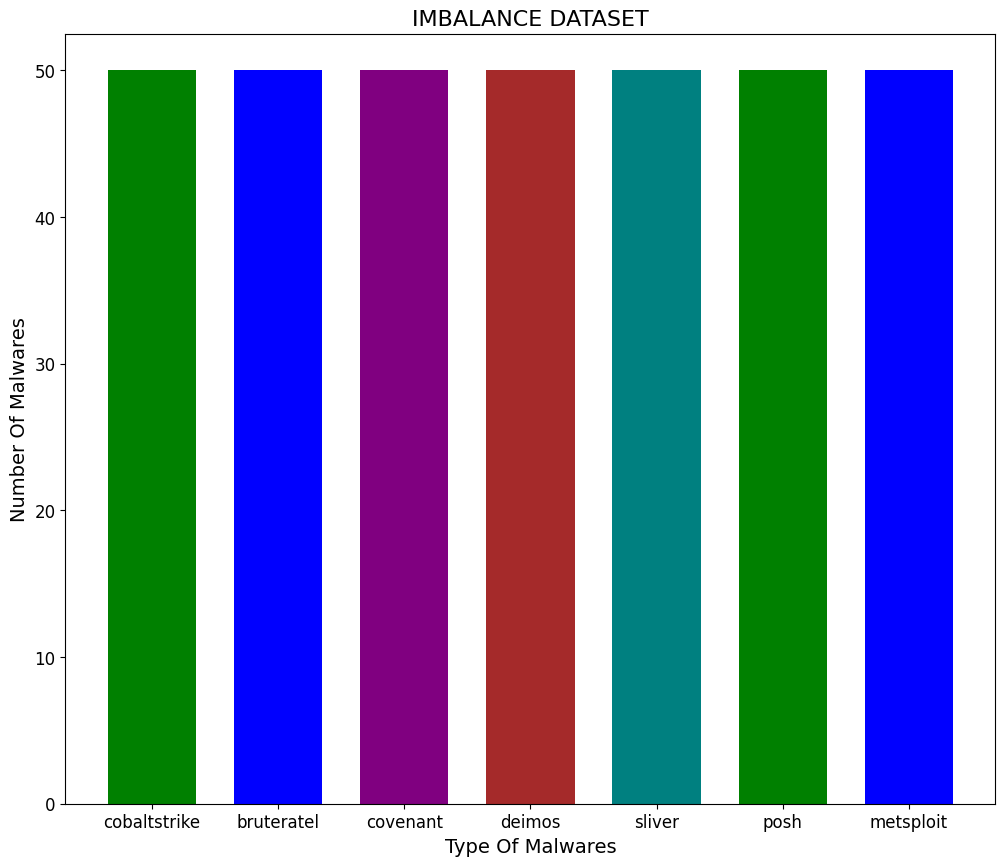

In [25]:
balanced_dataset_size = balanced_dataset["label"].value_counts().to_dict()
balanced_dataset_size = {k: v for k, v in sorted(list(balanced_dataset_size.items()))}

names = list(dataset_label.values())
values = list(balanced_dataset_size.values())
New_Colors = ["green","blue","purple","brown","teal"]
plt.figure(figsize=(12,10))
plt.bar(names,values,color=New_Colors,width=0.7)
plt.xticks(fontsize= 12 )
plt.yticks(fontsize= 12)
plt.title("IMBALANCE DATASET",fontsize=16)
plt.xlabel("Type Of Malwares", fontsize=14)
plt.ylabel("Number Of Malwares", fontsize=14)
plt.show()

#Classifier

In [26]:
X = balanced_dataset[["data_vector_mean", "data_vector_std", "node", "edge"]]
y = balanced_dataset["label"]

In [27]:
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5
)

xgb_classifier = XGBClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    min_child_weight=1
)

lgbm_classifier = LGBMClassifier(
    learning_rate=0.1,
    n_estimators=200,
    max_depth=6,
    min_child_samples=10
)

svc_classifier = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale'
)

catboost_classifier = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1
)

classifiers = [
    rf_classifier,
    xgb_classifier,
    lgbm_classifier,
    svc_classifier,
    catboost_classifier
]

In [28]:
results = {clf.__class__.__name__: {"accuracy": [], "precision": [], "recall": [], "f1": []} for clf in classifiers}

In [29]:
for clf in classifiers:
    for _ in tqdm(range(10)):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average="weighted")
        recall = recall_score(y_test, y_pred, average="weighted")
        f1 = f1_score(y_test, y_pred, average="weighted")

        results[clf.__class__.__name__]["accuracy"].append(accuracy)
        results[clf.__class__.__name__]["precision"].append(precision)
        results[clf.__class__.__name__]["recall"].append(recall)
        results[clf.__class__.__name__]["f1"].append(f1)

  0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [W

 10%|█         | 1/10 [00:00<00:07,  1.14it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.873589
[LightGBM] [Info] Start training from score -

 20%|██        | 2/10 [00:01<00:06,  1.15it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -2.051271
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -

 30%|███       | 3/10 [00:02<00:05,  1.18it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.873589
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [W

 40%|████      | 4/10 [00:03<00:05,  1.15it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 167
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.828127
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -

 50%|█████     | 5/10 [00:04<00:04,  1.15it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 159
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -2.108429
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.828127
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -

 60%|██████    | 6/10 [00:05<00:03,  1.16it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.921218
[LightGBM] [Info] Start training from score -

 70%|███████   | 7/10 [00:06<00:02,  1.14it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 155
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -

 80%|████████  | 8/10 [00:06<00:01,  1.15it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -1.971228
[LightGBM] [Info] Start training from score -1.897120
[LightGBM] [Info] Start training from score -1.873589
[LightGBM] [Info] Start training from score -1.997203
[LightGBM] [Info] Start training from score -

 90%|█████████ | 9/10 [00:07<00:00,  1.16it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 161
[LightGBM] [Info] Number of data points in the train set: 280, number of used features: 4
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -2.023872
[LightGBM] [Info] Start training from score -1.850600
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -

100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


  0%|          | 0/10 [00:00<?, ?it/s]

0:	learn: 1.8224800	total: 50.2ms	remaining: 9.99s
1:	learn: 1.6801599	total: 53.4ms	remaining: 5.28s
2:	learn: 1.5968964	total: 56.2ms	remaining: 3.69s
3:	learn: 1.5382151	total: 63.7ms	remaining: 3.12s
4:	learn: 1.4640692	total: 67.3ms	remaining: 2.62s
5:	learn: 1.4271416	total: 74ms	remaining: 2.39s
6:	learn: 1.3708522	total: 77ms	remaining: 2.12s
7:	learn: 1.3133244	total: 86.2ms	remaining: 2.07s
8:	learn: 1.2674469	total: 87.8ms	remaining: 1.86s
9:	learn: 1.2297017	total: 91.4ms	remaining: 1.74s
10:	learn: 1.1918523	total: 95ms	remaining: 1.63s
11:	learn: 1.1472726	total: 98.6ms	remaining: 1.54s
12:	learn: 1.1185136	total: 102ms	remaining: 1.47s
13:	learn: 1.0901040	total: 106ms	remaining: 1.4s
14:	learn: 1.0710431	total: 108ms	remaining: 1.34s
15:	learn: 1.0451166	total: 112ms	remaining: 1.28s
16:	learn: 1.0146928	total: 115ms	remaining: 1.23s
17:	learn: 0.9913044	total: 118ms	remaining: 1.19s
18:	learn: 0.9770635	total: 121ms	remaining: 1.15s
19:	learn: 0.9575449	total: 124ms	re

 10%|█         | 1/10 [00:01<00:12,  1.39s/it]

192:	learn: 0.2635171	total: 1.14s	remaining: 41.3ms
193:	learn: 0.2626407	total: 1.15s	remaining: 35.4ms
194:	learn: 0.2616368	total: 1.15s	remaining: 29.5ms
195:	learn: 0.2604412	total: 1.15s	remaining: 23.5ms
196:	learn: 0.2597711	total: 1.16s	remaining: 17.6ms
197:	learn: 0.2589237	total: 1.16s	remaining: 11.7ms
198:	learn: 0.2581892	total: 1.17s	remaining: 5.86ms
199:	learn: 0.2576173	total: 1.17s	remaining: 0us
0:	learn: 1.7944856	total: 8.82ms	remaining: 1.75s
1:	learn: 1.6697493	total: 15ms	remaining: 1.48s
2:	learn: 1.5803564	total: 21.5ms	remaining: 1.41s
3:	learn: 1.5108109	total: 26.1ms	remaining: 1.28s
4:	learn: 1.4380681	total: 33.8ms	remaining: 1.32s
5:	learn: 1.3920639	total: 38ms	remaining: 1.23s
6:	learn: 1.3362318	total: 45.7ms	remaining: 1.26s
7:	learn: 1.2806385	total: 50.1ms	remaining: 1.2s
8:	learn: 1.2368149	total: 58.7ms	remaining: 1.25s
9:	learn: 1.1977458	total: 63.7ms	remaining: 1.21s
10:	learn: 1.1551228	total: 69.6ms	remaining: 1.2s
11:	learn: 1.1170796	to

 20%|██        | 2/10 [00:02<00:08,  1.08s/it]

174:	learn: 0.2977208	total: 668ms	remaining: 95.4ms
175:	learn: 0.2961070	total: 673ms	remaining: 91.7ms
176:	learn: 0.2948292	total: 679ms	remaining: 88.2ms
177:	learn: 0.2941064	total: 683ms	remaining: 84.4ms
178:	learn: 0.2925256	total: 688ms	remaining: 80.7ms
179:	learn: 0.2916911	total: 691ms	remaining: 76.8ms
180:	learn: 0.2904908	total: 694ms	remaining: 72.8ms
181:	learn: 0.2891738	total: 696ms	remaining: 68.9ms
182:	learn: 0.2885052	total: 699ms	remaining: 64.9ms
183:	learn: 0.2877294	total: 701ms	remaining: 61ms
184:	learn: 0.2866226	total: 704ms	remaining: 57.1ms
185:	learn: 0.2849542	total: 706ms	remaining: 53.2ms
186:	learn: 0.2843764	total: 709ms	remaining: 49.3ms
187:	learn: 0.2835991	total: 712ms	remaining: 45.4ms
188:	learn: 0.2829566	total: 715ms	remaining: 41.6ms
189:	learn: 0.2821817	total: 717ms	remaining: 37.8ms
190:	learn: 0.2810764	total: 720ms	remaining: 33.9ms
191:	learn: 0.2798996	total: 723ms	remaining: 30.1ms
192:	learn: 0.2791342	total: 726ms	remaining: 26

 30%|███       | 3/10 [00:03<00:06,  1.08it/s]

0:	learn: 1.8237801	total: 7.11ms	remaining: 1.41s
1:	learn: 1.7035018	total: 11.2ms	remaining: 1.11s
2:	learn: 1.6063359	total: 14ms	remaining: 920ms
3:	learn: 1.5430435	total: 17.1ms	remaining: 840ms
4:	learn: 1.4770415	total: 20.2ms	remaining: 787ms
5:	learn: 1.4210572	total: 25.9ms	remaining: 837ms
6:	learn: 1.3615788	total: 29ms	remaining: 798ms
7:	learn: 1.2996823	total: 31.9ms	remaining: 766ms
8:	learn: 1.2557027	total: 34.1ms	remaining: 723ms
9:	learn: 1.2212496	total: 37.3ms	remaining: 708ms
10:	learn: 1.1746814	total: 40.3ms	remaining: 692ms
11:	learn: 1.1361109	total: 43.4ms	remaining: 680ms
12:	learn: 1.0989554	total: 46.6ms	remaining: 671ms
13:	learn: 1.0757106	total: 49.6ms	remaining: 659ms
14:	learn: 1.0595143	total: 52.7ms	remaining: 650ms
15:	learn: 1.0371364	total: 55.7ms	remaining: 641ms
16:	learn: 1.0165117	total: 58.7ms	remaining: 632ms
17:	learn: 0.9910871	total: 61.8ms	remaining: 625ms
18:	learn: 0.9753567	total: 64.9ms	remaining: 618ms
19:	learn: 0.9524220	total

 40%|████      | 4/10 [00:03<00:05,  1.16it/s]

177:	learn: 0.2815426	total: 581ms	remaining: 71.8ms
178:	learn: 0.2799165	total: 586ms	remaining: 68.7ms
179:	learn: 0.2781606	total: 592ms	remaining: 65.8ms
180:	learn: 0.2768562	total: 600ms	remaining: 63ms
181:	learn: 0.2759813	total: 603ms	remaining: 59.6ms
182:	learn: 0.2752671	total: 606ms	remaining: 56.3ms
183:	learn: 0.2743318	total: 609ms	remaining: 52.9ms
184:	learn: 0.2724290	total: 612ms	remaining: 49.6ms
185:	learn: 0.2709011	total: 615ms	remaining: 46.3ms
186:	learn: 0.2693464	total: 618ms	remaining: 43ms
187:	learn: 0.2681502	total: 621ms	remaining: 39.6ms
188:	learn: 0.2674769	total: 624ms	remaining: 36.3ms
189:	learn: 0.2662267	total: 627ms	remaining: 33ms
190:	learn: 0.2653230	total: 630ms	remaining: 29.7ms
191:	learn: 0.2647008	total: 633ms	remaining: 26.4ms
192:	learn: 0.2636831	total: 636ms	remaining: 23.1ms
193:	learn: 0.2627350	total: 639ms	remaining: 19.8ms
194:	learn: 0.2614800	total: 642ms	remaining: 16.5ms
195:	learn: 0.2609344	total: 645ms	remaining: 13.2ms

 50%|█████     | 5/10 [00:04<00:04,  1.23it/s]

198:	learn: 0.2758824	total: 638ms	remaining: 3.2ms
199:	learn: 0.2753569	total: 643ms	remaining: 0us
0:	learn: 1.8089623	total: 3.06ms	remaining: 610ms
1:	learn: 1.6747032	total: 7.98ms	remaining: 791ms
2:	learn: 1.5736264	total: 12ms	remaining: 791ms
3:	learn: 1.4972380	total: 15.5ms	remaining: 762ms
4:	learn: 1.4170052	total: 18.9ms	remaining: 737ms
5:	learn: 1.3769433	total: 22.3ms	remaining: 721ms
6:	learn: 1.3343073	total: 25.4ms	remaining: 701ms
7:	learn: 1.2755155	total: 28.6ms	remaining: 685ms
8:	learn: 1.2170193	total: 31.4ms	remaining: 666ms
9:	learn: 1.1736693	total: 34.2ms	remaining: 649ms
10:	learn: 1.1294118	total: 37.4ms	remaining: 642ms
11:	learn: 1.0964267	total: 40.6ms	remaining: 635ms
12:	learn: 1.0638330	total: 43.7ms	remaining: 629ms
13:	learn: 1.0335986	total: 47.1ms	remaining: 626ms
14:	learn: 1.0063343	total: 50.6ms	remaining: 624ms
15:	learn: 0.9818144	total: 53.6ms	remaining: 616ms
16:	learn: 0.9511643	total: 56.6ms	remaining: 610ms
17:	learn: 0.9353911	total

 60%|██████    | 6/10 [00:05<00:03,  1.26it/s]

162:	learn: 0.2979118	total: 545ms	remaining: 124ms
163:	learn: 0.2958584	total: 550ms	remaining: 121ms
164:	learn: 0.2942051	total: 556ms	remaining: 118ms
165:	learn: 0.2926208	total: 562ms	remaining: 115ms
166:	learn: 0.2911346	total: 566ms	remaining: 112ms
167:	learn: 0.2902218	total: 569ms	remaining: 108ms
168:	learn: 0.2895929	total: 572ms	remaining: 105ms
169:	learn: 0.2888376	total: 575ms	remaining: 102ms
170:	learn: 0.2862922	total: 578ms	remaining: 98.1ms
171:	learn: 0.2854832	total: 581ms	remaining: 94.7ms
172:	learn: 0.2843802	total: 584ms	remaining: 91.2ms
173:	learn: 0.2831538	total: 587ms	remaining: 87.8ms
174:	learn: 0.2823443	total: 590ms	remaining: 84.3ms
175:	learn: 0.2812751	total: 593ms	remaining: 80.9ms
176:	learn: 0.2796010	total: 596ms	remaining: 77.5ms
177:	learn: 0.2779352	total: 599ms	remaining: 74.1ms
178:	learn: 0.2765501	total: 602ms	remaining: 70.7ms
179:	learn: 0.2741698	total: 606ms	remaining: 67.3ms
180:	learn: 0.2730164	total: 609ms	remaining: 63.9ms
1

 70%|███████   | 7/10 [00:05<00:02,  1.28it/s]

186:	learn: 0.2786995	total: 616ms	remaining: 42.8ms
187:	learn: 0.2777751	total: 621ms	remaining: 39.7ms
188:	learn: 0.2756248	total: 626ms	remaining: 36.5ms
189:	learn: 0.2745961	total: 634ms	remaining: 33.3ms
190:	learn: 0.2740127	total: 640ms	remaining: 30.2ms
191:	learn: 0.2725058	total: 646ms	remaining: 26.9ms
192:	learn: 0.2716697	total: 649ms	remaining: 23.5ms
193:	learn: 0.2695683	total: 652ms	remaining: 20.1ms
194:	learn: 0.2686111	total: 655ms	remaining: 16.8ms
195:	learn: 0.2671586	total: 658ms	remaining: 13.4ms
196:	learn: 0.2665430	total: 661ms	remaining: 10.1ms
197:	learn: 0.2652419	total: 664ms	remaining: 6.71ms
198:	learn: 0.2644510	total: 667ms	remaining: 3.35ms
199:	learn: 0.2631516	total: 670ms	remaining: 0us
0:	learn: 1.8277138	total: 6.51ms	remaining: 1.3s
1:	learn: 1.7141257	total: 10.6ms	remaining: 1.04s
2:	learn: 1.6287731	total: 13.3ms	remaining: 874ms
3:	learn: 1.5655904	total: 16ms	remaining: 785ms
4:	learn: 1.4912915	total: 18.7ms	remaining: 728ms
5:	learn:

 80%|████████  | 8/10 [00:06<00:01,  1.32it/s]

156:	learn: 0.3369753	total: 485ms	remaining: 133ms
157:	learn: 0.3351827	total: 490ms	remaining: 130ms
158:	learn: 0.3339166	total: 496ms	remaining: 128ms
159:	learn: 0.3325959	total: 503ms	remaining: 126ms
160:	learn: 0.3311558	total: 508ms	remaining: 123ms
161:	learn: 0.3292810	total: 511ms	remaining: 120ms
162:	learn: 0.3280500	total: 514ms	remaining: 117ms
163:	learn: 0.3269376	total: 517ms	remaining: 113ms
164:	learn: 0.3256574	total: 520ms	remaining: 110ms
165:	learn: 0.3245476	total: 523ms	remaining: 107ms
166:	learn: 0.3235187	total: 526ms	remaining: 104ms
167:	learn: 0.3224192	total: 529ms	remaining: 101ms
168:	learn: 0.3208858	total: 531ms	remaining: 97.5ms
169:	learn: 0.3198415	total: 534ms	remaining: 94.3ms
170:	learn: 0.3181426	total: 537ms	remaining: 91.1ms
171:	learn: 0.3172140	total: 540ms	remaining: 87.9ms
172:	learn: 0.3163227	total: 543ms	remaining: 84.8ms
173:	learn: 0.3151848	total: 546ms	remaining: 81.6ms
174:	learn: 0.3142623	total: 549ms	remaining: 78.4ms
175:	

 90%|█████████ | 9/10 [00:07<00:00,  1.33it/s]

184:	learn: 0.2694162	total: 595ms	remaining: 48.3ms
185:	learn: 0.2683629	total: 600ms	remaining: 45.2ms
186:	learn: 0.2671067	total: 606ms	remaining: 42.2ms
187:	learn: 0.2667485	total: 612ms	remaining: 39.1ms
188:	learn: 0.2657139	total: 617ms	remaining: 35.9ms
189:	learn: 0.2652589	total: 622ms	remaining: 32.8ms
190:	learn: 0.2645779	total: 625ms	remaining: 29.4ms
191:	learn: 0.2630399	total: 628ms	remaining: 26.1ms
192:	learn: 0.2619431	total: 630ms	remaining: 22.8ms
193:	learn: 0.2607619	total: 633ms	remaining: 19.6ms
194:	learn: 0.2598413	total: 638ms	remaining: 16.4ms
195:	learn: 0.2589304	total: 641ms	remaining: 13.1ms
196:	learn: 0.2578182	total: 643ms	remaining: 9.8ms
197:	learn: 0.2572142	total: 646ms	remaining: 6.52ms
198:	learn: 0.2565369	total: 648ms	remaining: 3.26ms
199:	learn: 0.2554941	total: 651ms	remaining: 0us
0:	learn: 1.8000036	total: 7.47ms	remaining: 1.49s
1:	learn: 1.6626782	total: 12.7ms	remaining: 1.26s
2:	learn: 1.5703969	total: 15.7ms	remaining: 1.03s
3:	

100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


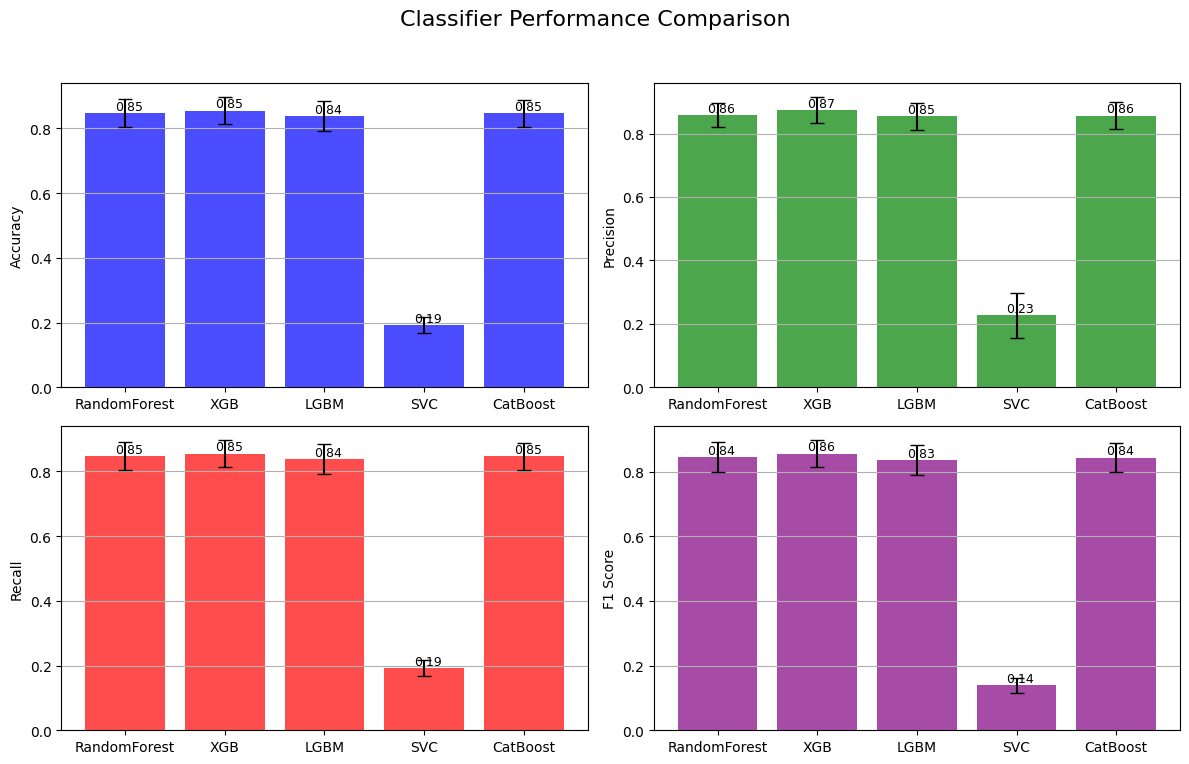

In [30]:
classifiers_names = [clf.__class__.__name__ for clf in classifiers]
accuracy_means = [np.mean(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_means = [np.mean(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_means = [np.mean(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_means = [np.mean(results[clf_name]["f1"]) for clf_name in classifiers_names]

accuracy_stds = [np.std(results[clf_name]["accuracy"]) for clf_name in classifiers_names]
precision_stds = [np.std(results[clf_name]["precision"]) for clf_name in classifiers_names]
recall_stds = [np.std(results[clf_name]["recall"]) for clf_name in classifiers_names]
f1_stds = [np.std(results[clf_name]["f1"]) for clf_name in classifiers_names]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Classifier Performance Comparison", fontsize=16)
classifiers_names = [clf.__class__.__name__.replace("Classifier", "") for clf in classifiers]

# Accuracy
bars = axes[0, 0].bar(classifiers_names, accuracy_means, yerr=accuracy_stds, capsize=5, color="b", alpha=0.7)
axes[0, 0].set_ylabel("Accuracy")
axes[0, 0].grid(axis="y")
for bar, acc in zip(bars, accuracy_means):
    axes[0, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, acc + 0.01, f"{acc:.2f}", fontsize=9)

# Precision
bars = axes[0, 1].bar(classifiers_names, precision_means, yerr=precision_stds, capsize=5, color="g", alpha=0.7)
axes[0, 1].set_ylabel("Precision")
axes[0, 1].grid(axis="y")
for bar, prec in zip(bars, precision_means):
    axes[0, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, prec + 0.01, f"{prec:.2f}", fontsize=9)

# Recall
bars = axes[1, 0].bar(classifiers_names, recall_means, yerr=recall_stds, capsize=5, color="r", alpha=0.7)
axes[1, 0].set_ylabel("Recall")
axes[1, 0].grid(axis="y")
for bar, rec in zip(bars, recall_means):
    axes[1, 0].text(bar.get_x() + bar.get_width() / 2 - 0.1, rec + 0.01, f"{rec:.2f}", fontsize=9)

# F1 Score
bars = axes[1, 1].bar(classifiers_names, f1_means, yerr=f1_stds, capsize=5, color="purple", alpha=0.7)
axes[1, 1].set_ylabel("F1 Score")
axes[1, 1].grid(axis="y")
for bar, f1 in zip(bars, f1_means):
    axes[1, 1].text(bar.get_x() + bar.get_width() / 2 - 0.1, f1 + 0.01, f"{f1:.2f}", fontsize=9)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()